## Goal of the project: Generate a short-term temperature forecast of Berlin Tempelhof 

##### Data: Temperature data from www.ecad.eu , data availability : 02/01/1876 till 31/12/2022

### Things achieved :
##### > Building a baseline model and modelling its trend and seasonality

##### > Plotting and analysing the different components of the time series

##### > Modelling the time dependence of the remainder using an AutoRegressive model

##### > Comparing the statistical output of different AutoRegressive models

##### > Forecasting the temperature for 1st January 2023


Time-series for temperature 



In [259]:
# Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec

from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import ar_select_order

#### Read the Data File

In [260]:
df = pd.read_csv('/home/myunix/TahiniTensor/spiced_projects/week7/ECA_blended_custom/TG_STAID002759.txt', skiprows=19, skipinitialspace=True, parse_dates=True, index_col=1)

In [261]:
# Check the data
#df.head(3), df.tail(3)
#df.columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53691 entries, 1876-01-01 to 2022-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SOUID   53691 non-null  int64
 1   TG      53691 non-null  int64
 2   Q_TG    53691 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


#### Data Checking and Cleaning

In [262]:
# Add extra columns year, month, day to the data frame
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df.head(3)

SOUID  TG  Q_TG  year  month  day
DATE                                          
1876-01-01  127488  22     0  1876      1    1
1876-01-02  127488  25     0  1876      1    2
1876-01-03  127488   3     0  1876      1    3

In [263]:
# Check NaN values
df.isnull().any()

SOUID    False
TG       False
Q_TG     False
year     False
month    False
day      False
dtype: bool

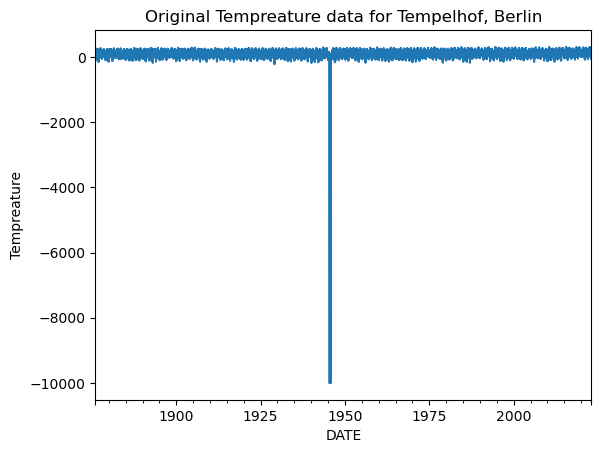

In [264]:
# Plot the Data
#df.plot(kind = line, x= year, y=TG )
df['TG'].plot( ylabel='Tempreature', title='Original Tempreature data for Tempelhof, Berlin')
plt.show()

In [265]:
# The are -9999 values in the data, the website also confirms this. 
# Fill the missing values

prior_year = df["1944-04-25": "1944-11-05"]["TG"].to_numpy()
post_year =  df["1946-04-25": "1946-11-05"]["TG"].to_numpy()
war_year = (prior_year + post_year) /2
df.loc["1945-04-25":"1945-11-05","TG"] = war_year

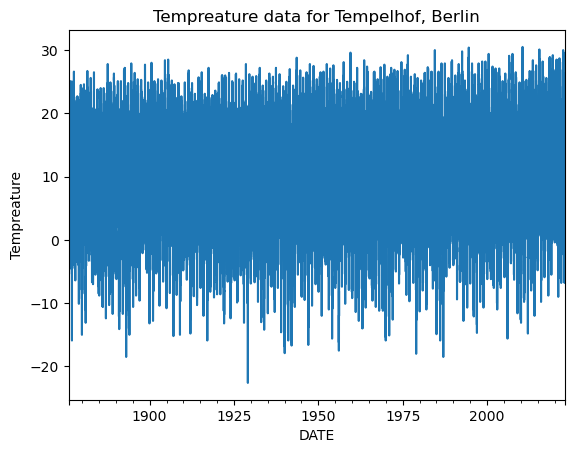

In [266]:
# The temperature units are in 1/10 of Degree Celcius. 
df['TG']= df['TG'] * 0.1                        # Convert in to readable tempreature units (degree Celcius) by multiplying 0.1

# Plot
df['TG'].plot(x='year', ylabel='Tempreature', title='Tempreature data for Tempelhof, Berlin')
plt.show()

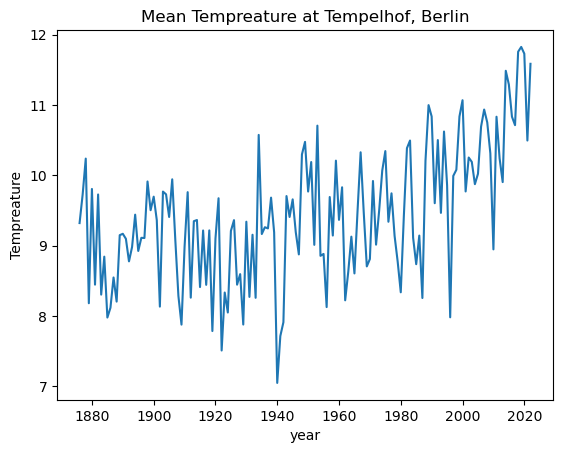

In [267]:
# Check by plotting the mean Tempreature 
df.groupby('year')['TG'].mean().plot(ylabel='Tempreature', title='Mean Tempreature at Tempelhof, Berlin')
plt.show()

In [268]:
# Create a funtion for future plotting
def plot_temp(df, title='Tempreature changes over years', ylim=True):
    df.plot()
    plt.title(title)
    plt.ylabel('Tempreature')
    #if ylim:
    #    plt.ylim(ymin=0)
    plt.show()

#### Decomposing Time Series Data

###### Time series data = trend + seasonality + remainder
###### We need to extract them one by one

##### Extract Trend

In [269]:
# Model the trend : Create a timestep variable
df['timestep'] = list(range(len(df['TG'])))
df.head(3)

SOUID   TG  Q_TG  year  month  day  timestep
DATE                                                     
1876-01-01  127488  2.2     0  1876      1    1         0
1876-01-02  127488  2.5     0  1876      1    2         1
1876-01-03  127488  0.3     0  1876      1    3         2

In [270]:
# Run a Linear Regression
model = LinearRegression()
X = df[['timestep']]
y =df.TG
model.fit(X, y)

LinearRegression()

In [271]:
# Use the model to make a prediction
df['trend'] = model.predict(X)

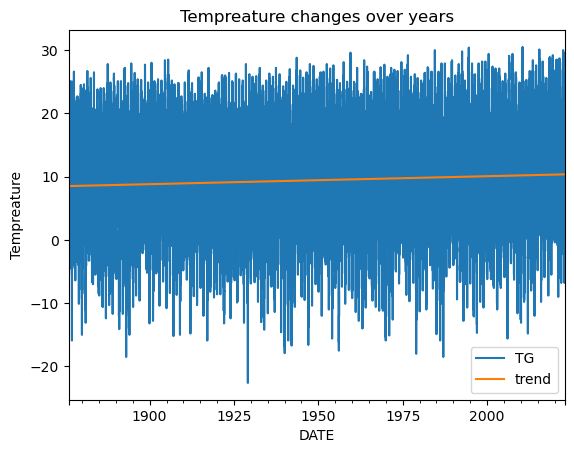

In [272]:
# Plot the trend and original temperature
plot_temp(df[['TG', 'trend']])

In [273]:
# And Plot with "plotly" for a better interactive visualisation
px.scatter(df[['TG','trend']])

In [274]:
# Check the intercept and coefficient of the Trend
print('Model Intercept   : ', model.intercept_)
print('Model coefficient : ', model.coef_)

Model Intercept   :  8.507077711415983
Model coefficient :  [3.44652313e-05]


##### Extract Seasonality


In [275]:
#  One-hot encode the months
pd.get_dummies(df.month,prefix='month')                         # create dummies 
seasonal_dummies = pd.get_dummies(df.month,prefix='month')
df = df.join(seasonal_dummies)                                  # join the created dummies to our original dataframe

In [276]:
# Define X and y
X = df.drop(columns=['TG', 'month', 'trend'])                   # define X and drop unnecessary columns

model.fit(X, y)                                                 # Fit the LinearRegression model

df['trend_seasonal'] = model.predict(X)                         # Predict the seasonility 
df.head(3)

SOUID   TG  Q_TG  year  month  day  timestep     trend  month_1  \
DATE                                                                           
1876-01-01  127488  2.2     0  1876      1    1         0  8.507078        1   
1876-01-02  127488  2.5     0  1876      1    2         1  8.507112        1   
1876-01-03  127488  0.3     0  1876      1    3         2  8.507147        1   

            month_2  ...  month_4  month_5  month_6  month_7  month_8  \
DATE                 ...                                                
1876-01-01        0  ...        0        0        0        0        0   
1876-01-02        0  ...        0        0        0        0        0   
1876-01-03        0  ...        0        0        0        0        0   

            month_9  month_10  month_11  month_12  trend_seasonal  
DATE                                                               
1876-01-01        0         0         0         0       -0.792420  
1876-01-02        0         0         0         0       -0.796569  
1876-01-03        0         0         0         0       -0.800718  

[3 rows x 21 columns]

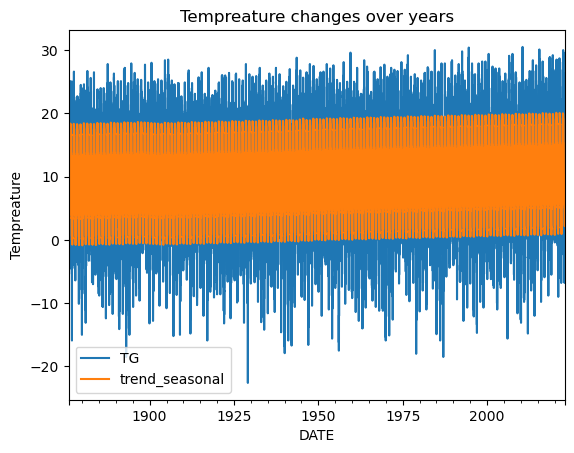

In [277]:
# Plot the trend and the seasonality
plot_temp(df[['TG', 'trend_seasonal']])

##### Extract Remainder

In [278]:
df['remainder'] = df.TG - df.trend_seasonal
#plot_temp(df['remainder'], title='Remainder after modelling trend and seasonality', ylim=False
#px.scatter(df[['TG','trend']])

<AxesSubplot: title={'center': 'Temperature in deg Celcius'}, xlabel='DATE', ylabel='Tempreature'>

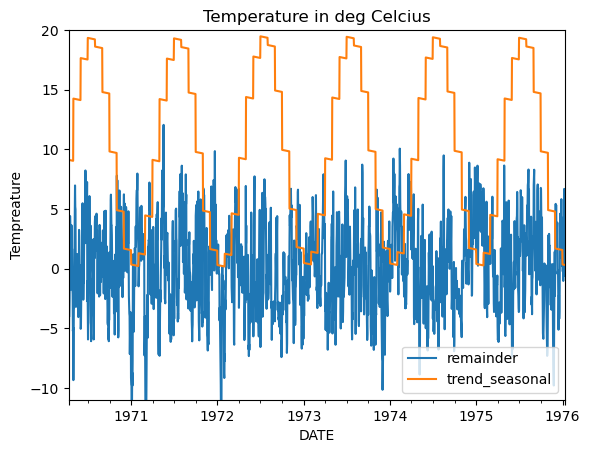

In [279]:
# Plot Remainder and Seasonality
df['remainder'].plot(xlim=[100,2200],ylim=[-11,20], legend='remainder')
df['trend_seasonal'].plot(xlim=[100,2200],ylim=[-11,20], ylabel='Tempreature', title='Temperature in deg Celcius', legend='seasonal')

##### Create a time-lagged input feature: lag1

In [280]:
df['lag1'] = df['remainder'].shift(1)

In [281]:
df.corr()

SOUID        TG          Q_TG          year  \
SOUID           1.000000e+00 -0.059895  6.155382e-02 -8.653943e-01   
TG             -5.989458e-02  1.000000  4.304631e-02  6.653989e-02   
Q_TG            6.155382e-02  0.043046  1.000000e+00 -5.691458e-03   
year           -8.653943e-01  0.066540 -5.691458e-03  1.000000e+00   
month           3.373528e-05  0.190011  1.678990e-02 -6.907719e-06   
day            -3.695529e-05  0.003844  9.414002e-04  7.942696e-06   
timestep       -8.653768e-01  0.067810 -5.578132e-03  9.999769e-01   
trend          -8.653768e-01  0.067810 -5.578132e-03  9.999769e-01   
month_1         2.436372e-06 -0.363875 -1.838676e-02 -1.604024e-06   
month_2        -8.219491e-05 -0.310796 -1.747880e-02  1.819313e-05   
month_3         7.734170e-06 -0.202558 -1.838676e-02 -1.604024e-06   
month_4         7.597047e-06 -0.021913 -1.129502e-02 -1.575585e-06   
month_5         7.734170e-06  0.174716  1.605257e-02 -1.604024e-06   
month_6         7.597047e-06  0.300697  1.576797e-02 -1.575585e-06   
month_7         7.734170e-06  0.371537  1.605257e-02 -1.604024e-06   
month_8         7.734170e-06  0.343308  1.605257e-02 -1.604024e-06   
month_9         7.597047e-06  0.192496  1.576797e-02 -1.575585e-06   
month_10        7.734170e-06  0.003323  1.605257e-02 -1.604024e-06   
month_11        7.597047e-06 -0.183804 -1.242264e-02 -1.575585e-06   
month_12        7.734170e-06 -0.311791 -1.838676e-02 -1.604024e-06   
trend_seasonal -6.906996e-02  0.867158  4.964067e-02  7.673327e-02   
remainder      -4.307180e-13  0.498033  1.044915e-13 -7.983058e-13   
lag1            8.777505e-05  0.407176 -2.918862e-04 -1.177111e-04   

                       month           day      timestep         trend  \
SOUID           3.373528e-05 -3.695529e-05 -8.653768e-01 -8.653768e-01   
TG              1.900107e-01  3.844468e-03  6.780971e-02  6.780971e-02   
Q_TG            1.678990e-02  9.414002e-04 -5.578132e-03 -5.578132e-03   
year           -6.907719e-06  7.942696e-06  9.999769e-01  9.999769e-01   
month           1.000000e+00  1.055024e-02  6.772032e-03  6.772032e-03   
day             1.055024e-02  1.000000e+00  6.460089e-04  6.460089e-04   
timestep        6.772032e-03  6.460089e-04  1.000000e+00  1.000000e+00   
trend           6.772032e-03  6.460089e-04  1.000000e+00  1.000000e+00   
month_1        -4.877186e-01  9.362884e-03 -3.285371e-03 -3.285371e-03   
month_2        -3.796884e-01 -3.631067e-02 -2.550114e-03 -2.550114e-03   
month_3        -3.111047e-01  9.362884e-03 -2.121276e-03 -2.121276e-03   
month_4        -2.188477e-01 -7.799877e-03 -1.495001e-03 -1.495001e-03   
month_5        -1.344908e-01  9.362884e-03 -9.226949e-04 -9.226949e-04   
month_6        -4.536506e-02 -7.799877e-03 -3.176706e-04 -3.176706e-04   
month_7         4.212306e-02  9.362884e-03  2.758862e-04  2.758862e-04   
month_8         1.304300e-01  9.362884e-03  8.850012e-04  8.850012e-04   
month_9         2.148588e-01 -7.799877e-03  1.457976e-03  1.457976e-03   
month_10        3.070439e-01  9.362884e-03  2.083582e-03  2.083582e-03   
month_11        3.883414e-01 -7.799877e-03  2.635307e-03  2.635307e-03   
month_12        4.836577e-01  9.362884e-03  3.282163e-03  3.282163e-03   
trend_seasonal  2.191189e-01  4.433410e-03  7.819762e-02  7.819762e-02   
remainder      -6.333867e-13 -3.694311e-14 -8.000835e-13 -7.999884e-13   
lag1            2.594779e-03 -5.737657e-03 -1.035118e-04 -1.035118e-04   

                     month_1       month_2  ...       month_6       month_7  \
SOUID           2.436372e-06 -8.219491e-05  ...  7.597047e-06  7.734170e-06   
TG             -3.638751e-01 -3.107959e-01  ...  3.006969e-01  3.715373e-01   
Q_TG           -1.838676e-02 -1.747880e-02  ...  1.576797e-02  1.605257e-02   
year           -1.604024e-06  1.819313e-05  ... -1.575585e-06 -1.604024e-06   
month          -4.877186e-01 -3.796884e-01  ... -4.536506e-02  4.212306e-02   
day             9.362884e-03 -3.631067e-02  ... -7.799877e-03  9.362884e-03   
timestep    

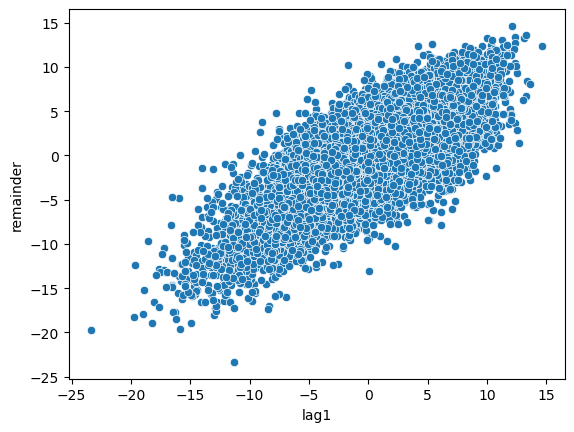

In [282]:
# Plot Remainder against lag1
sns.scatterplot(x='lag1', y='remainder', data=df);

The Autoregressive Model (AR)

In [283]:
# Dropping the NaN values. 
df.dropna(inplace=True)                                 # A NaN value is generated during the shifting of the shells in lag1

In [284]:
# Create and fit the model
X = df[['lag1']] ; y = df['remainder']                  # Define X and y

# m0del = LinearRegression()                            # Our model is already defined above
model.fit(X, y)

LinearRegression()

In [285]:
# Create predictions
df['predictions_ar1'] = model.predict(X)

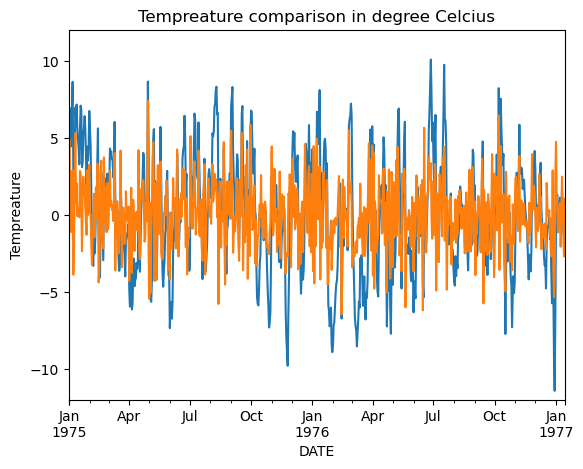

In [286]:
# Plot the original remainder and the prediction
df['remainder'].plot(ylim=[-12,12], xlim=[1825,2570])                           # Plotting for Two years only for better visualisation
(df['remainder'] - df['predictions_ar1']).plot(ylim=[-12,12], xlim=[1825,2570],
                     ylabel='Tempreature', title='Tempreature comparison in degree Celcius')
plt.show()

In [287]:
# Add more lags to check there relevance
df['lag2'] = df['remainder'].shift(2)
df['lag3'] = df['remainder'].shift(3)
df['lag4'] = df['remainder'].shift(4)

# And Check the correlations of the lags
corelation = round(df[['remainder', 'lag1', 'lag2','lag3','lag4']].corr(), 2)
corelation

remainder  lag1  lag2  lag3  lag4
remainder       1.00  0.80   0.6  0.46  0.37
lag1            0.80  1.00   0.8  0.60  0.46
lag2            0.60  0.80   1.0  0.80  0.60
lag3            0.46  0.60   0.8  1.00  0.80
lag4            0.37  0.46   0.6  0.80  1.00

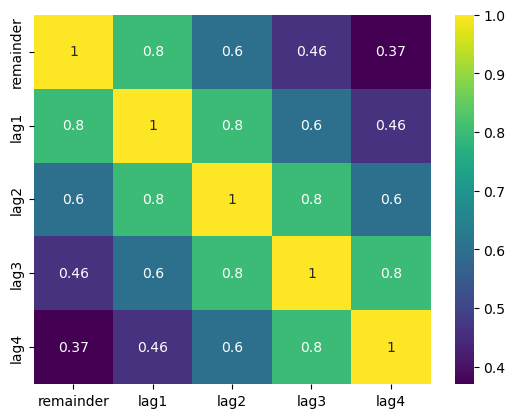

In [288]:
# Plot the correlation of the lags
sns.heatmap(corelation, annot=True, fmt="g", cmap='viridis')
plt.show()

Implement and Plot Autocorrelations

Text(0.5, 0, 'lags')

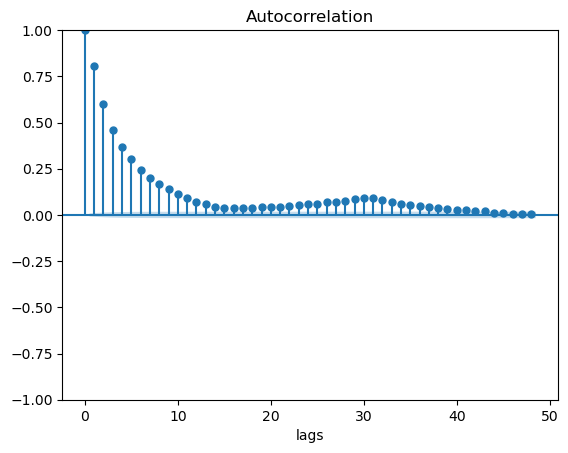

In [289]:
# Auto Correlation
plot_acf(df['remainder'])
plt.xlabel('lags')

/home/myunix/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



Text(0.5, 0, 'lags')

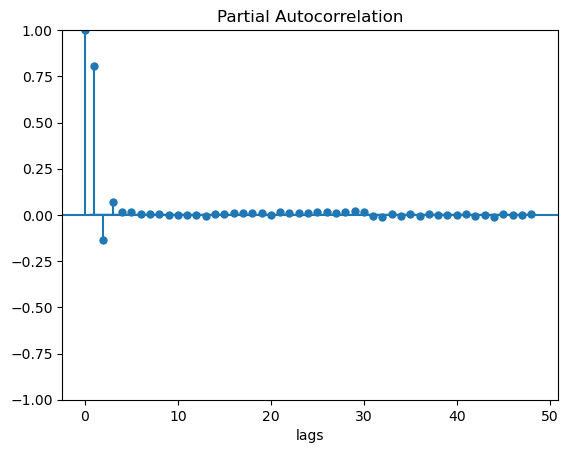

In [290]:
# Partial Auto Correlation
plot_pacf(df['remainder'])
plt.xlabel('lags')

In [291]:
# Implement and Check, Box-Jenkins-Methodology
lags_order = ar_select_order(df['remainder'], maxlag=5)             # checking for 5 lags
lags_order.bic

/home/myunix/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/myunix/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



{(1, 2, 3, 4): 242186.79121787215,
 (1, 2, 3, 4, 5): 242187.2983323852,
 (1, 2, 3): 242189.89417173588,
 (1, 2): 242441.752064867,
 (1,): 243397.6608468007,
 0: 299126.25033065665}

In [292]:
# The above analysis checks the relevance of lags of 'remainder', and 
# will be useful for our predictions.

#### Evaluate the Model

##### Using Timeseriessplit method

In [293]:
# Assign X and y

X_full = df.drop(['SOUID', 'TG', 'Q_TG','year','month','day','trend','trend_seasonal','remainder','predictions_ar1'], axis=1)
y_full = df['TG'][4:]

In [294]:
# Create a TimeSeriesSplit object

X_full.dropna(inplace=True)                         # Removing the NaN values first

ts_split = TimeSeriesSplit(n_splits=25)             # Splitting for 25 sets

In [295]:
# Create the model and predict
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [296]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full)

In [297]:
# The Validation scores
result = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=time_series_split)

print('The scores of R^2 : ',result)

print('Average of the above R^2 : ',round(result.mean(), 3))

The scores of R^2 :  [0.90330843 0.92648425 0.92257543 0.9157258  0.91092772 0.90113707
 0.89343905 0.89528561 0.90763957 0.91113609 0.91551142 0.91805638
 0.92167414 0.91014396 0.91208246 0.91561999 0.90470002 0.911215
 0.90899657 0.90168136 0.90592843 0.92390381 0.92309045 0.91846204
 0.91578621]
Average of the above R^2 :  0.912


#### Predict the future

##### predict the tempreature for 1st Jan 2023 at Tempelhof, Berlin

In [298]:
# New timestep is added:
timestep = df['timestep'].max() + 1
months = [1] + [0] * 11                             # array of zeroes for months

lag1 = df.loc['2022-12-31', 'remainder']            # Defining the lags:
lag2 = df.loc['2022-12-30', 'remainder']            # Fours lags are taken since they are important as seen
lag3 = df.loc['2022-12-29', 'remainder']            # from the Partial autocorrelation and Box-Jenkins-Methodology.
lag4 = df.loc['2022-12-28', 'remainder']


In [299]:
# Create a new dataframe for the future data point
# with our above input
X_future = [timestep]
X_future.extend(months)
X_future.append(lag1)
X_future.append(lag2)
X_future.append(lag3)
X_future.append(lag4)
X_future = pd.DataFrame([X_future])
X_future.columns = X_full.columns
X_future

timestep  month_1  month_2  month_3  month_4  month_5  month_6  month_7  \
0     53691        1        0        0        0        0        0        0   

   month_8  month_9  month_10  month_11  month_12       lag1      lag2  \
0        0        0         0         0         0  12.587367  5.383218   

       lag3     lag4  
0  7.779069  4.07492

In [300]:
# Prediction for the Next day (1st Jan 2023) 
m_full.predict(X_future)

array([11.98192394])